##### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import imageio
from PIL import Image
import ipyplot
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score

##### Exploring the data

In [2]:
import pathlib
data_dir = "hpa-single-cell-image-classification/train"
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = os.listdir(data_dir)
len(image_count)

87224

In [4]:
df_train = pd.read_csv("hpa-single-cell-image-classification/train.csv")
df_train.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [5]:
df_samp_sub = pd.read_csv("hpa-single-cell-image-classification/sample_submission.csv")
df_samp_sub.head()

,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==


In [6]:
train_images = "hpa-single-cell-image-classification/train"
train_images = os.listdir(train_images)
#train_images

### Note
*  the following code below shows that there are 4 images in the train folder assoicated with the image ID that corresponds to Red, Blue, Green, and Yellow channels...In other words, 4 images per ID that are differentiated by color (Red, Blue, Green, Yellow)

In [7]:
len(df_train), len(train_images), len(train_images)/len(df_train)

(21806, 87224, 4.0)

##### Number of labels per images
* We can see that there are more than 10,000 images that are composed of 1 label out of the 18 labels so due to space constraints we will stick with the 1 label images

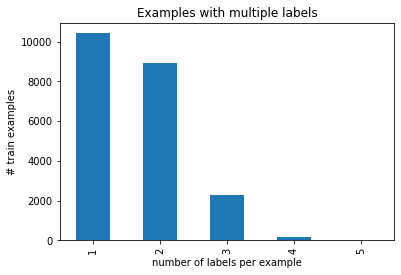

In [8]:
df_train['num_classes'] = df_train['Label'].apply(lambda r: len(r.split('|')))
df_train['num_classes'].value_counts().plot.bar(title='Examples with multiple labels', xlabel='number of labels per example', ylabel='# train examples')
plt.show()

##### Things to keep in mind regarding channels
* Red (Microtubules)
* Green (Protein of interest)
* Blue (Nucleus)
* Yellow (Endoplasmic reticulum)

##### Here we seperate the images based on the ID and color

In [9]:
path = "hpa-single-cell-image-classification"
mt = [path+'/train/'+(id+'_red.png') for id in df_train.ID.values]
er = [path+'/train/'+(id+'_yellow.png') for id in df_train.ID.values]
nu = [path+'/train/'+(id+'_blue.png') for id in df_train.ID.values]
pr = [path+'/train/'+(id+'_green.png') for id in df_train.ID.values]
images = [mt, er, nu, pr]
titles = ['microtubules', 'endoplasmic reticulum', 'nucleus', 'protein of interest']

##### Viewing the images 
* Images by themselves (no stack)

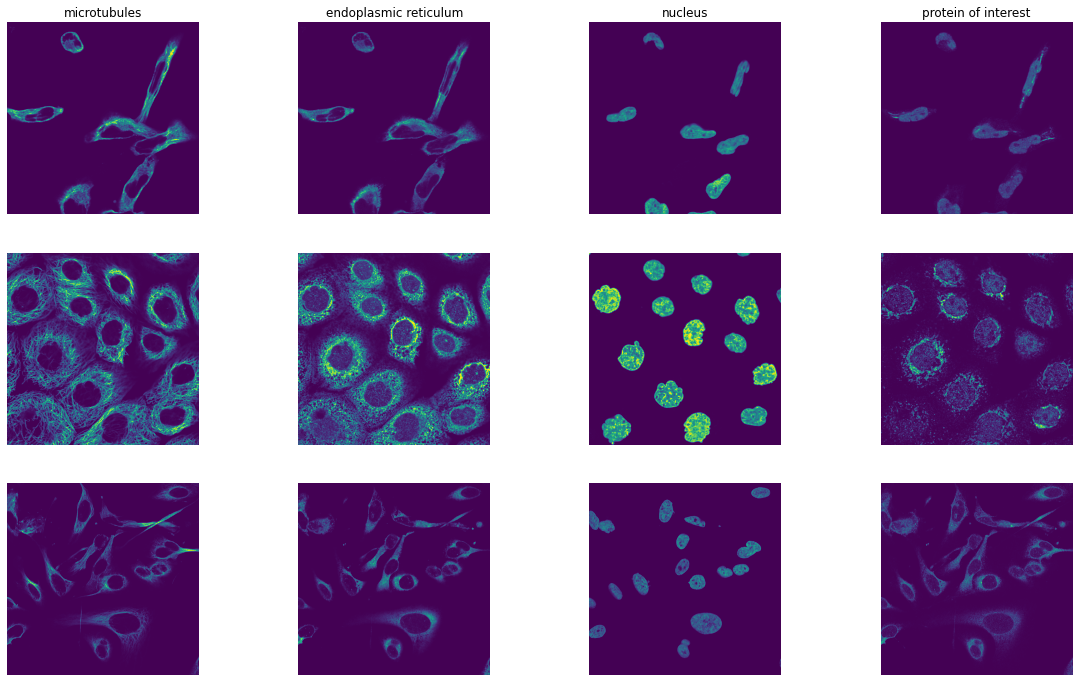

In [10]:
fig, ax = plt.subplots(3,4, figsize=(20,12))
for j in range(3):
    for i in range(4):
        img = plt.imread(images[i][j])
        if j == 0: ax[j,i].set_title(titles[i])
        ax[j,i].imshow(img)
        ax[j,i].axis('off')
plt.show()

##### Generating stacked Images
* These are images stacked (red, yellow, blue)


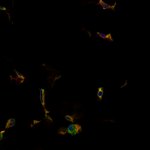
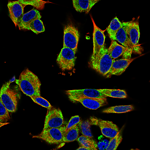
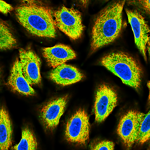
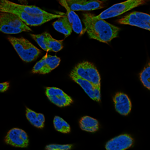
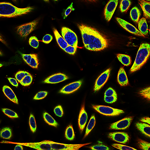
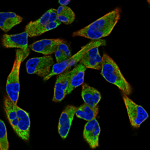
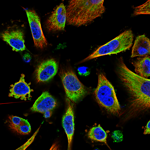
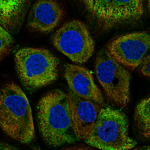
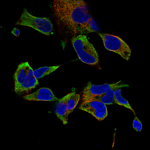
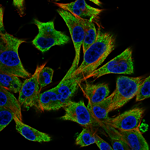
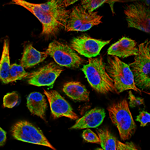
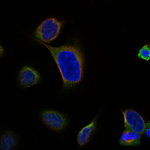
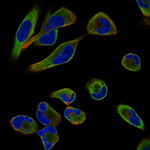
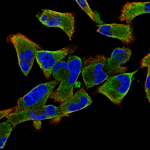
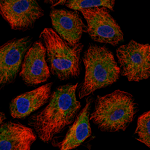
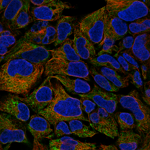
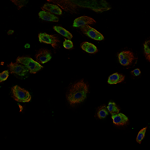
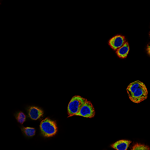
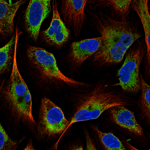


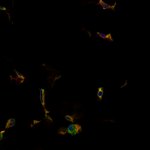
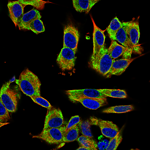
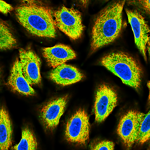
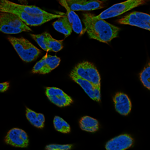
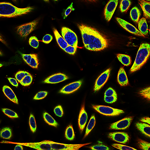
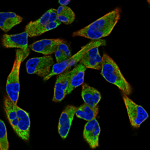
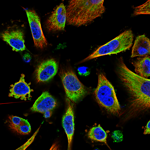
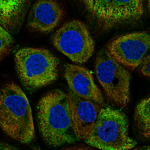
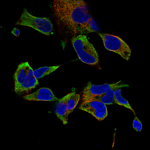
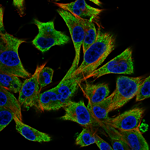
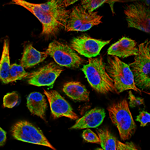
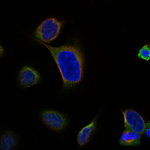
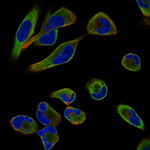
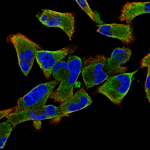
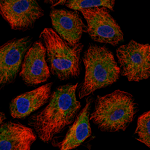
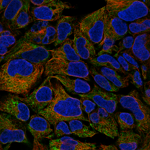
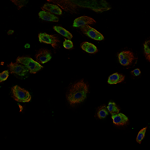
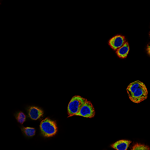
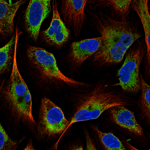

In [11]:
labels = [str(i) for i in range(19)]
class_images = []
for label in labels:
    r_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_red.png'
    y_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_yellow.png'
    b_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_blue.png'
    r = imageio.imread(path+'/train/'+r_img)
    y = imageio.imread(path+'/train/'+y_img)
    b = imageio.imread(path+'/train/'+b_img)
    rgb = np.dstack((r,y,b))
    #print(r.shape)
    class_images.append(PIL.Image.frombytes('RGB',r.shape,rgb))

codes = [
'0. Nucleoplasm',
'1. Nuclear membrane',
'2. Nucleoli',
'3. Nucleoli fibrillar center',
'4. Nuclear speckles',
'5. Nuclear bodies',
'6. Endoplasmic reticulum',
'7. Golgi apparatus',
'8. Intermediate filaments',
'9. Actin filaments',
'10. Microtubules',
'11. Mitotic spindle',
'12. Centrosome',
'13. Plasma membrane',
'14. Mitochondria',
'15. Aggresome',
'16. Cytosol',
'17. Vesicles and punctate cytosolic patterns',
'18. Negative'
]

#ipyplot.plot_images(images=class_images, labels=codes, max_images=19, img_width=300)
ipyplot.plot_images(images=class_images, labels=codes, max_images=19)

##### Generating directories and saving images with respect to the labels associated to the images

In [27]:
len(df_train[df_train.Label == "1"])

221

In [30]:
img_counter = len(df_train[df_train.Label == label])
print(img_counter)
for i in range(img_counter):
    print(i)

34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [31]:
# per label 
labels = [str(i) for i in range(19)]
code = [
'00_Nucleoplasm',
'01_Nuclear_membrane',
'02_Nucleoli',
'03_Nucleoli_fibrillar_center',
'04_Nuclear_speckles',
'05_Nuclear_bodies',
'06_Endoplasmic_reticulum',
'07_Golgi_apparatus',
'08_Intermediate_filaments',
'09_Actin_filaments',
'10_Microtubules',
'11_Mitotic_spindle',
'12_Centrosome',
'13_Plasma_membrane',
'14_Mitochondria',
'15_Aggresome',
'16_Cytosol',
'17_Vesicles_and_punctate_cytosolic_patterns',
'18_Negative'
]

for label in labels:
    img_counter = len(df_train[df_train.Label == label])
    print("Generating Images for "+code[int(label)] )
    for i in range(img_counter):
        try:
            r_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[i] + '_red.png'
            y_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[i] + '_yellow.png'
            b_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[i] + '_blue.png'
            name = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[i]

            r = imageio.imread(path+'/train/'+r_img)
            y = imageio.imread(path+'/train/'+y_img)
            b = imageio.imread(path+'/train/'+b_img)
            rgb = np.dstack((r,y,b))
            
            image_name = PIL.Image.frombytes('RGB',r.shape,rgb)
            resized_image = image_name.resize((180,180))

            if not os.path.exists("data/"+code[int(label)]):
                os.makedirs("data/"+code[int(label)])

            resized_image.save("data/"+code[int(label)]+"/"+ name + ".png")
        except:
            print("Unable to save image with this label: "+ code[int(label)])
    
    print("Completed Generating Images for "+code[int(label)])


Generating Images for 00_Nucleoplasm
Completed Generating Images for 00_Nucleoplasm
Generating Images for 01_Nuclear_membrane
Completed Generating Images for 01_Nuclear_membrane
Generating Images for 02_Nucleoli
Completed Generating Images for 02_Nucleoli
Generating Images for 03_Nucleoli_fibrillar_center
Completed Generating Images for 03_Nucleoli_fibrillar_center
Generating Images for 04_Nuclear_speckles
Completed Generating Images for 04_Nuclear_speckles
Generating Images for 05_Nuclear_bodies
Completed Generating Images for 05_Nuclear_bodies
Generating Images for 06_Endoplasmic_reticulum
Completed Generating Images for 06_Endoplasmic_reticulum
Generating Images for 07_Golgi_apparatus
Completed Generating Images for 07_Golgi_apparatus
Generating Images for 08_Intermediate_filaments
Completed Generating Images for 08_Intermediate_filaments
Generating Images for 09_Actin_filaments
Completed Generating Images for 09_Actin_filaments
Generating Images for 10_Microtubules
Completed Genera

##### Size of images and batch size variables

In [18]:
batch_size = 32
img_height = 180
img_width = 180

##### Training Data Generator

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
 "./data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3317 files belonging to 19 classes.
Using 2654 files for training.


##### Validation Data Generator

In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3317 files belonging to 19 classes.
Using 663 files for validation.


##### Training Data

In [21]:
x_train = list()
y_train = list()
for raw_data,labels in train_ds:
    y_train.extend(np.array(labels))
   # print(labels)
    for image_data_per in raw_data:
        x_train.append(np.array(image_data_per))
x_train = np.array(x_train).reshape(-1,(180*180*3))
#print(x_train.shape)
y_train = np.array(y_train)
#print(y_train.shape)

##### Validation data

In [22]:
x_test = list()
y_test = list()
for raw_data,labels in val_ds:
    y_test.extend(np.array(labels))
    #print(labels)
    for image_data_per in raw_data:
        x_test.append(np.array(image_data_per))
x_test = np.array(x_test).reshape(-1,(180*180*3))
#print(x_test.shape)
y_test = np.array(y_test)
#print(y_test.shape)

##### SVM Classifer

In [53]:
pipe = make_pipeline(StandardScaler(), SVC(gamma='auto',probability=True))
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print(classification_report(y_test,y_pred))
precision = precision_score(y_test, y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred,average='weighted')
print('F1 score: %f' % f1)

              precision    recall  f1-score   support

           0       0.06      0.10      0.07        41
           1       0.10      0.18      0.12        39
           2       0.12      0.09      0.11        43
           3       0.16      0.08      0.11        38
           4       0.00      0.00      0.00        41
           5       0.09      0.24      0.13        34
           6       0.17      0.12      0.14        42
           7       0.17      0.02      0.04        46
           8       0.00      0.00      0.00        39
           9       0.18      0.29      0.22        34
          10       0.05      0.14      0.07        37
          12       0.00      0.00      0.00        35
          13       0.20      0.02      0.04        51
          14       0.00      0.00      0.00        44
          15       0.00      0.00      0.00        16
          16       0.07      0.28      0.12        36
          17       0.00      0.00      0.00        41
          18       0.00    

c:\users\micha\anaconda3\envs\py3_base\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\micha\anaconda3\envs\py3_base\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\micha\anaconda3\envs\py3_base\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mich

##### Random Forest Classifer

In [23]:
pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print(classification_report(y_test,y_pred))
precision = precision_score(y_test, y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred,average='weighted')
print('F1 score: %f' % f1)


              precision    recall  f1-score   support

           0       0.17      0.20      0.18        41
           1       0.07      0.08      0.07        39
           2       0.08      0.07      0.07        43
           3       0.08      0.11      0.09        38
           4       0.07      0.07      0.07        41
           5       0.02      0.03      0.02        34
           6       0.08      0.10      0.09        42
           7       0.11      0.09      0.10        46
           8       0.03      0.03      0.03        39
           9       0.14      0.18      0.16        34
          10       0.09      0.11      0.10        37
          12       0.00      0.00      0.00        35
          13       0.31      0.16      0.21        51
          14       0.18      0.14      0.15        44
          15       0.00      0.00      0.00        16
          16       0.18      0.31      0.23        36
          17       0.12      0.07      0.09        41
          18       1.00    

c:\users\micha\anaconda3\envs\py3_base\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\micha\anaconda3\envs\py3_base\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\micha\anaconda3\envs\py3_base\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\mich

#### XGBoost Classifer

In [ ]:
pipe = make_pipeline(StandardScaler(), XGBClassifier())
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print(classification_report(y_test,y_pred))
precision = precision_score(y_test, y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred,average='weighted')
print('F1 score: %f' % f1)

c:\users\micha\anaconda3\envs\py3_base\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:19:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
! 